we have:

    at q state
    po q state
    po m div
    po q div
    at q zip3
    at y zip3
    at y tract
    
at y state -> at y county -> at y tract    

or 

at y state -> at y zip3 -> at y zip5  

a zip code may be shared by two couties. a tract may have multiple zips.


po m div -> po q state -> at y state -> at y county -> at y tract

or 

po m div -> po q state -> at y state -> at y zip3 -> at y zip5



# county monthly

In [2]:
%reset -f

In [3]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [4]:
state_po_monthly=pd.read_csv("../input/third2/HPI_po_state_monthly_arima.csv", parse_dates=['Month']).set_index('Month')
print state_po_monthly.columns
state_po_monthly.columns=['36','39','19','37','06']

Index([u'NY', u'OH', u'IA', u'NC', u'CA'], dtype='object')


In [5]:
dict(zip ([u'NY', u'OH', u'IA', u'NC', u'CA'],['36','39','19','37','06']))

{u'CA': '06', u'IA': '19', u'NC': '37', u'NY': '36', u'OH': '39'}

In [6]:
state_po_monthly.head()

36          39          19          37          06
Month                                                                 
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000
1991-02-01  100.040000  101.000000  100.610000  100.520000  100.210000
1991-03-01   99.930000  101.350000  100.410000  100.970000  100.000000
1991-04-01   99.330001  101.730924  101.466203  100.888174   99.574089
1991-05-01   99.590001  102.350747  101.245012  100.748274   99.812685

In [7]:
state_po_monthly.index.max()

Timestamp('2018-12-01 00:00:00')

In [8]:
county_at_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_county_5state_arima.csv", dtype={'FIPS code':np.str}).set_index("FIPS code").T
county_at_hpi.index=pd.to_datetime(['{}-07-01'.format(u) for u in county_at_hpi.index])

In [9]:
county_at_hpi.index.max()

Timestamp('2018-07-01 00:00:00')

In [10]:
county_at_hpi.tail()

FIPS code         06001      06003       06005       06007       06009  \
2014-07-01  1241.380000  174.11000  245.880000  607.450000  255.390000   
2015-07-01  1349.540000  152.00000  268.500000  629.420000  277.030000   
2016-07-01  1500.750000  158.89000  294.620000  673.290000  300.470000   
2017-07-01  1626.370000  161.48332  317.730000  719.960000  328.340000   
2018-07-01  1691.265361  158.89000  331.354544  753.305348  349.404172   

FIPS code        06011        06013      06015      06017       06019  \
2014-07-01  246.220000   935.220000  325.63000  688.83000  535.740000   
2015-07-01  260.730000   995.460000  337.61000  722.40000  562.770000   
2016-07-01  281.290000  1096.170000  363.64000  780.16000  594.510000   
2017-07-01  299.300000  1197.700000  392.77000  843.65000  646.830000   
2018-07-01  307.762616  1250.401152  415.05027  887.34849  688.363156   

FIPS code      ...           39157       39159       39161      39163  \
2014-07-01     ...      281.740000  359.210000  180.770000  130.50000   
2015-07-01     ...      288.450000  377.020000  192.110000  132.59834   
2016-07-01     ...      299.630000  394.960000  187.810000  135.45000   
2017-07-01     ...      310.470000  418.080000  192.920000  127.09000   
2018-07-01     ...      319.182659  437.237417  191.790592  127.09000   

FIPS code        39165       39167      39169       39171       39173  \
2014-07-01  319.200000  222.510000  304.00000  173.870000  257.030000   
2015-07-01  331.260000  234.730000  324.19000  179.590000  262.990000   
2016-07-01  342.600000  239.060000  332.05000  185.260000  271.570000   
2017-07-01  363.650000  243.030000  350.16000  188.720000  281.090000   
2018-07-01  382.149778  247.355304  364.88424  192.405838  288.955245   

FIPS code        39175  
2014-07-01  199.020000  
2015-07-01  204.170000  
2016-07-01  211.520000  
2017-07-01  223.490000  
2018-07-01  232.578411  

[5 rows x 402 columns]

In [11]:
src=state_po_monthly.sort_index()
target=county_at_hpi.sort_index()

In [12]:
from dateutil.relativedelta import relativedelta

In [13]:
def make_year(yr):
    return pd.to_datetime(['{}-{}-01'.format(yr,m) for m in range(1,13)])

In [14]:
def make_src_ratio(src,yr):
    quarter_dts1=make_year(yr)
    quarter_dts2=make_year(yr-1)
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [15]:
make_year(target.index[0].year)

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01', '1991-11-01', '1991-12-01'],
              dtype='datetime64[ns]', freq=None)

In [16]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        dt=dt.year
        quarter_dts=make_year(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [17]:
len(target.columns)

402

In [18]:
dest=[]
for col in target.columns[:]:
    target_s=target[col]
    src_s=src[col[:2]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns[:len(dest)],index=src.index)

218 37005


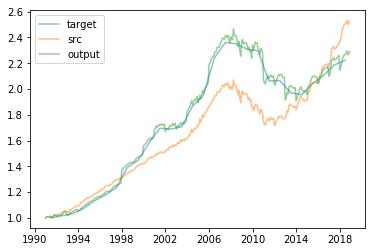

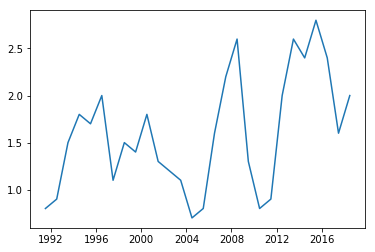

77 19043


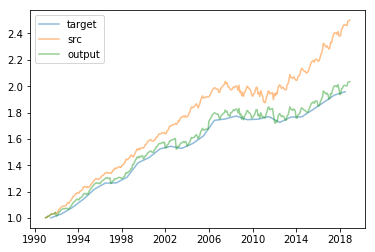

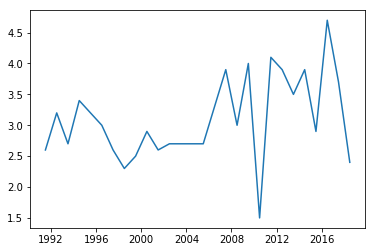

43 06087


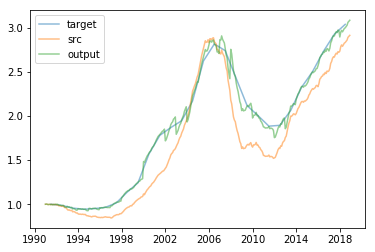

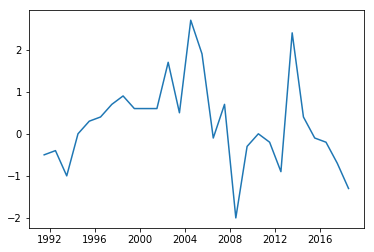

367 39107


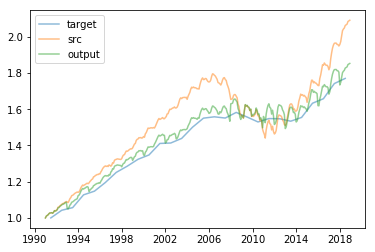

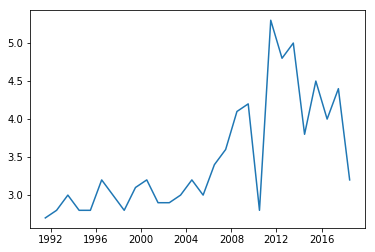

195 36083


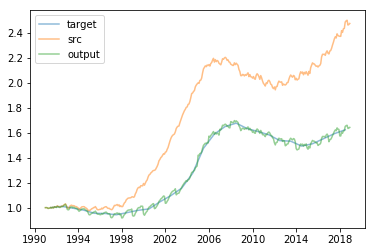

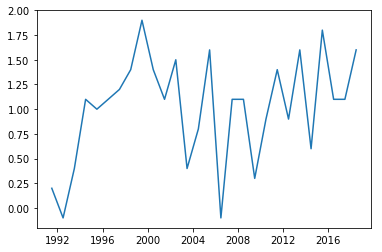

257 37083


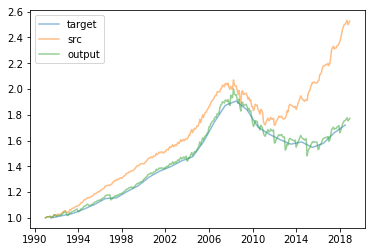

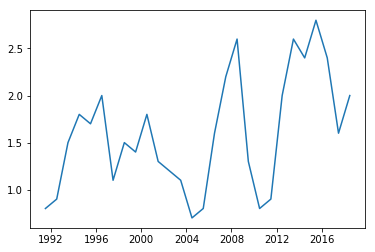

261 37091


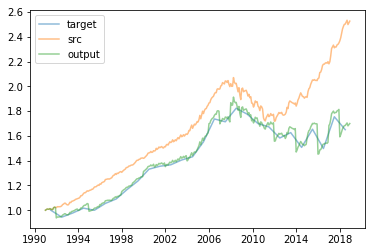

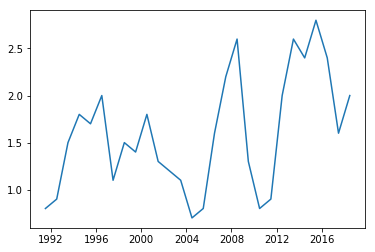

11 06023


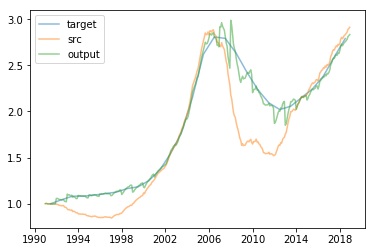

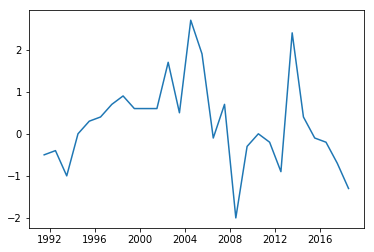

333 39039


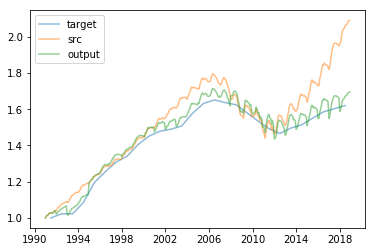

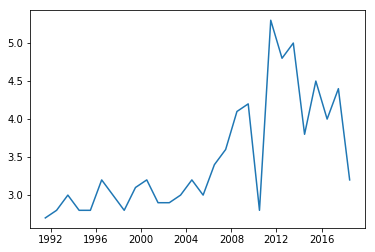

319 39011


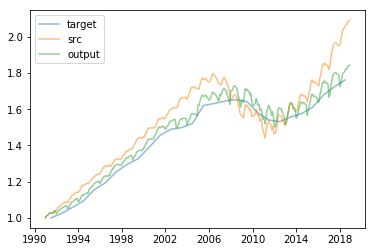

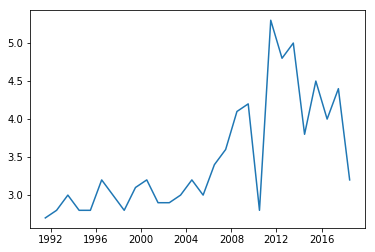

In [19]:
f=lambda u:u/u[0]
for i in np.random.choice(range(len(dest.columns)),10):
    print i, dest.columns[i] 
    plt.plot(f(target.iloc[:,i]),alpha=0.5)
    plt.plot(f(src.loc[:,dest.columns[i][:2]]),alpha=0.5)
    plt.plot(f(dest.iloc[:,i]),alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(f(dest.iloc[:,i])/f(target.iloc[:,i])-1),1).dropna())
    plt.show()

In [22]:
dest.tail(10)

FIPS code        06001       06003       06005       06007       06009  \
Month                                                                    
2018-03-01  338.575213  151.510039  185.889839  220.813686  199.543158   
2018-04-01  336.645385  150.646454  184.830295  219.555081  198.405792   
2018-05-01  338.840638  151.628815  186.035567  220.986792  199.699589   
2018-06-01  341.035035  152.610792  187.240369  222.417945  200.992882   
2018-07-01  341.878864  152.988400  187.703661  222.968278  201.490203   
2018-08-01  343.611596  153.763785  188.654993  224.098340  202.511408   
2018-09-01  345.217113  154.482243  189.536478  225.145433  203.457637   
2018-10-01  348.953949  156.154451  191.588135  227.582542  205.659984   
2018-11-01  350.360001  156.783649  192.360107  228.499548  206.488657   
2018-12-01  351.680457  157.374544  193.085084  229.360730  207.266883   

FIPS code        06011       06013       06015       06017       06019  \
Month                                                                    
2018-03-01  212.711363  268.363177  212.923203  226.916703  215.739503   
2018-04-01  211.498940  266.833547  211.709573  225.623312  214.509820   
2018-05-01  212.878117  268.573560  213.090124  227.094594  215.908632   
2018-06-01  214.256757  270.312893  214.470136  228.565302  217.306897   
2018-07-01  214.786896  270.981733  215.000804  229.130845  217.844584   
2018-08-01  215.875493  272.355140  216.090485  230.292141  218.948678   
2018-09-01  216.884165  273.627712  217.100162  231.368175  219.971710   
2018-10-01  219.231849  276.589623  219.450184  233.872642  222.352815   
2018-11-01  220.115208  277.704095  220.334422  234.814993  223.248749   
2018-12-01  220.944790  278.750721  221.164830  235.699977  224.090141   

FIPS code      ...           39157       39159       39161       39163  \
Month          ...                                                       
2018-03-01     ...      186.225054  202.683712  161.766796  166.653127   
2018-04-01     ...      189.073958  205.784403  164.241533  169.202615   
2018-05-01     ...      189.881049  206.662826  164.942623  169.924883   
2018-06-01     ...      190.425865  207.255793  165.415885  170.412440   
2018-07-01     ...      191.718367  208.662527  166.538633  171.569102   
2018-08-01     ...      192.087858  209.064674  166.859596  171.899760   
2018-09-01     ...      192.431419  209.438599  167.158035  172.207214   
2018-10-01     ...      193.768458  210.893806  168.319471  173.403732   
2018-11-01     ...      194.096221  211.250536  168.604186  173.697047   
2018-12-01     ...      194.421418  211.604475  168.886673  173.988067   

FIPS code        39165       39167       39169       39171       39173  \
Month                                                                    
2018-03-01  175.741743  202.814558  186.313417  155.986429  165.025972   
2018-04-01  178.430271  205.917251  189.163672  158.372736  167.550568   
2018-05-01  179.191927  206.796240  189.971146  159.048775  168.265783   
2018-06-01  179.706074  207.389590  190.516221  159.505125  168.748580   
2018-07-01  180.925816  208.797233  191.809336  160.587755  169.893949   
2018-08-01  181.274507  209.199639  192.179003  160.897250  170.221379   
2018-09-01  181.598728  209.573806  192.522727  161.185024  170.525831   
2018-10-01  182.860500  211.029952  193.860400  162.304959  171.710666   
2018-11-01  183.169811  211.386913  194.188318  162.579501  172.001118   
2018-12-01  183.476702  211.741080  194.513670  162.851893  172.289296   

FIPS code        39175  
Month                   
2018-03-01  197.951496  
2018-04-01  200.979792  
2018-05-01  201.837705  
2018-06-01  202.416828  
2018-07-01  203.790718  
2018-08-01  204.183476  
2018-09-01  204.548671  
2018-10-01  205.969902  
2018-11-01  206.318303  
2018-12-01  206.663978  

[10 rows x 402 columns]

In [21]:
dest.to_csv("../input/third2/HPI_at_county_monthly_arima.csv")